# Implemenation of Make Me a BNN


## Import libraries

### Install Missing Packages

In [1]:
!pip install netcal
!pip install torchsummary


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Import Used Libs

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os
import numpy as np
from torchsummary import summary
from torch.nn.functional import softmax
import torch.nn.functional as F
import netcal.metrics as metrics
from netcal.metrics import ECE
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve
from torch.utils.data import random_split
import multiprocessing
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from torchvision import datasets

### Import Custom Libs

In [33]:
import sys
# Get the current working directory of the notebook
current_dir = os.path.dirname(os.path.abspath('__file__'))
print(f"current dir is {current_dir}")
# Add the ABNN and 'Simple CNN Demo' directories to the Python path
abnn_dir = os.path.abspath(os.path.join(current_dir, './MakeMe-BNN/ABNN'))
print(f"ABNN dir is {abnn_dir}")
if abnn_dir not in sys.path:
    sys.path.insert(0, abnn_dir)

# Now import the necessary modules
from ABNN.MAP import CustomMAPLoss
from ABNN.bnl import BNL
# from ABNN import ABNN, test_and_eval, train
# from ABNN.datasets import dtd,imagenet,cifar10,cifar100,streethazards,svhn,bddanomaly,muad
# from ABNN.deep_learning_models import resnet,resnet_diff_arc,wide_resnet18_10,vit,deeplabv3plus_resnet50

current dir is /home/abduallah_damash/project/ceng502/MakeMe-BNN
ABNN dir is /home/abduallah_damash/project/ceng502/MakeMe-BNN/MakeMe-BNN/ABNN


### Set the device Usage:

In [18]:
multiprocessing.set_start_method('forkserver', force=True)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.backends.cudnn.benchmark = True

cuda


##  Dataset

### Load and Augment CIFAR-10 and CIFAR100

Similar to the paper, only used:
- Horizontal Flip for data augmentation.
- Batch size as 128.

#### Load the CIFAR10 dataset

In [6]:
def prepare_cifar10_data(batch_size=128, train_split_ratio=0.8, num_workers=2):
    """
    Prepares the CIFAR-10 dataset for training, validation, and testing.

    Parameters:
    - batch_size (int): The number of samples per batch to load. Default is 128.
    - train_split_ratio (float): The proportion of the dataset to include in the train split. Default is 0.8 (80%).
    - num_workers (int): How many subprocesses to use for data loading. Default is 2.

    Returns:
    - trainloader (DataLoader): DataLoader for the training set.
    - validloader (DataLoader): DataLoader for the validation set.
    - testloader (DataLoader): DataLoader for the test set.
    """
    # Define the transform
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load the CIFAR10 dataset
    full_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    # Split the dataset into training and validation sets
    train_size = int(train_split_ratio * len(full_trainset))  # 80% for training
    valid_size = len(full_trainset) - train_size  # 20% for validation
    train_subset, valid_subset = random_split(full_trainset, [train_size, valid_size])

    # Create DataLoaders
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    validloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Load the test set
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Print the sizes of the datasets
    print(f'CIFAR10 Training set size: {len(train_subset)}')
    print(f'CIFAR10 Validation set size: {len(valid_subset)}')
    print(f'CIFAR10 Test set size: {len(testset)}')

    return trainloader, validloader, testloader

# if __name__ == "__main__":
#     trainloader10, validloader10, testloader10 = prepare_cifar10_data()


#### Load the CIFAR100 dataset

In [7]:
def prepare_cifar100_data(batch_size=128, train_split_ratio=0.8, num_workers=2):
    """
    Prepares the CIFAR-100 dataset for training, validation, and testing.

    Parameters:
    - batch_size (int): The number of samples per batch to load. Default is 128.
    - train_split_ratio (float): The proportion of the dataset to include in the train split. Default is 0.8 (80%).
    - num_workers (int): How many subprocesses to use for data loading. Default is 2.

    Returns:
    - trainloader (DataLoader): DataLoader for the training set.
    - validloader (DataLoader): DataLoader for the validation set.
    - testloader (DataLoader): DataLoader for the test set.
    """
    # Define the transform
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load the CIFAR100 dataset
    full_trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

    # Split the dataset into training and validation sets
    train_size = int(train_split_ratio * len(full_trainset))  # 80% for training
    valid_size = len(full_trainset) - train_size  # 20% for validation
    train_subset, valid_subset = random_split(full_trainset, [train_size, valid_size])

    # Create DataLoaders
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    validloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Load the test set
    testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Print the sizes of the datasets
    print(f'CIFAR100 Training set size: {len(train_subset)}')
    print(f'CIFAR100 Validation set size: {len(valid_subset)}')
    print(f'CIFAR100 Test set size: {len(testset)}')

    return trainloader, validloader, testloader

# if __name__ == "__main__":
#     trainloader100, validloader100, testloader100 = prepare_cifar100_data()

In [9]:
def prepare_svhn_data(batch_size=128, train_split_ratio=0.8, num_workers=2):
    """
    Prepares the SVHN dataset for training, validation, and testing.

    Parameters:
    - batch_size (int): The number of samples per batch to load. Default is 128.
    - train_split_ratio (float): The proportion of the dataset to include in the train split. Default is 0.8 (80%).
    - num_workers (int): How many subprocesses to use for data loading. Default is 2.

    Returns:
    - trainloader (DataLoader): DataLoader for the training set.
    - validloader (DataLoader): DataLoader for the validation set.
    - testloader (DataLoader): DataLoader for the test set.
    """
    # Define the transform
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load the SVHN dataset
    full_trainset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)

    # Split the dataset into training and validation sets
    train_size = int(train_split_ratio * len(full_trainset))  # 80% for training
    valid_size = len(full_trainset) - train_size  # 20% for validation
    train_subset, valid_subset = random_split(full_trainset, [train_size, valid_size])

    # Create DataLoaders
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    validloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Load the test set
    testset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Print the sizes of the datasets
    print(f'SVHN Training set size: {len(train_subset)}')
    print(f'SVHN Validation set size: {len(valid_subset)}')
    print(f'SVHN Test set size: {len(testset)}')

    return trainloader, validloader, testloader

# if __name__ == "__main__":
#     trainloader_svhn, validloader_svhn, testloader_svhn = prepare_svhn_data()

## Define the DL model

### Define ResNen Model

- It can be used as ResNet18, ResNet34, ResNet50, ResNet101, ResNet152
- Added a dropout layer with P=0.3 to prevent overfitting. 

In [35]:
"""resnet in pytorch
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun.

    Deep Residual Learning for Image Recognition
    https://arxiv.org/abs/1512.03385v1
"""

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1,norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d        
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = norm_layer(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = norm_layer(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                norm_layer(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1,norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d        
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = norm_layer(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = norm_layer(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = norm_layer(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                norm_layer(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = norm_layer(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride,norm_layer=self._norm_layer))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    """ return a ResNet 34 object
    """
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(Bottleneck, [3, 4, 6, 3])

def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(Bottleneck, [3, 4, 23, 3])

def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(Bottleneck, [3, 8, 36, 3])

## Define Training and Tesing Loops

### Training Loop:

The `train_model` function is a versatile training loop designed for PyTorch models, providing flexibility in selecting optimizers, loss functions, and various hyperparameters. Here's a brief description of its key features and how it utilizes different parameters:

1. **Optimizer Selection**:
   - The function allows the choice between 'SGD' (Stochastic Gradient Descent) and 'Adam' optimizers via the `Optimizer_type` parameter. This is achieved by checking the value of `Optimizer_type` and initializing the respective optimizer with the specified `learning_rate`, `Weight_decay`, and `Momentum` (for SGD).

2. **Loss Function Selection**:
   - The function supports multiple loss functions, including 'CrossEntropyLoss', 'MSELoss', and a custom loss function 'CustomMAPLoss'. The appropriate loss function is selected based on the `Loss_fn` parameter. For 'CustomMAPLoss', the `Num_classes` and `Weight_decay` parameters are used for initialization.

3. **Learning Rate Scheduler**:
   - A MultiStepLR scheduler is used to adjust the learning rate at specified milestones. The `milestones` parameter defines the epochs at which the learning rate is reduced by a factor specified by `gamma_lr`.

4. **Training and Validation Loop**:
   - The function contains a standard training loop where it iterates over the training dataset, computes the loss, performs backpropagation, and updates the model parameters.
   - After each epoch, the model is evaluated on the validation dataset, and the average validation loss is computed and stored.

5. **Hyperparameters**:
   - Various hyperparameters such as `epochs`, `learning_rate`, `Weight_decay`, `Momentum`, and `Num_classes` can be adjusted to fine-tune the training process according to specific needs.

6. **Model Saving**:
   - The trained model's state dictionary is saved to a specified path (`save_path`) after the training is complete.

7. **Loss Visualization**:
   - The function plots the training and validation losses over epochs for easy visualization of the model's performance.


This design provides flexibility and ease of experimentation with different training configurations, making it suitable for various deep learning tasks.

In [41]:
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                epochs: int = 10, learning_rate: float = 0.005, gamma_lr: float = 0.1, 
                milestones: list = [5, 15], save_path: str = 'model.pth', Weight_decay: float = 5e-4,
                Momentum: float = 0.9, Optimizer_type: str = 'SGD',  Loss_fn: str = 'CrossEntropyLoss',
                Num_classes: int = 10, BNL_enable: bool = False, BNL_load_path: str = "model.pth") -> (list, list):
    """
    Trains the model and evaluates it on the validation set after each epoch.

    Parameters:
        model (nn.Module): The neural network model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        epochs (int): The number of epochs to train the model.
        learning_rate (float): The learning rate for the optimizer.
        gamma_lr (float): Factor by which the learning rate will be multiplied at each milestone.
        milestones (list): List of epoch indices at which to adjust the learning rate.
        save_path (str): Path to save the trained model state.
        Weight_decay (float): The weight decay for the optimizer.
        Momentum (float): The Momentum for the optimizer.
        Optimizer_type (str): The optimizer type.
        Loss_fn (str): The loss function type.
        Num_classes (int): Number of classes in the dataset.
        BNL_enable (bool): this to enable the training loop to load the trined wights of deep learning model.
        BNL_load_path (str): the loading path of the trined wights of deep learning model.


    Returns:
        train_losses (tuple): A tuple containing lists of training losses per epoch.
        val_losses (tuple): A tuple containing lists of validation losses per epoch.
    """    
    if BNL_enable:
        model.load_state_dict(torch.load(BNL_load_path),strict=False)
        print("BNL model loaded from {}".format(BNL_load_path))
        print('Model weights loaded.')

    if Optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=Momentum, weight_decay=Weight_decay)
    elif Optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=Weight_decay)
    else:
        raise ValueError("Unsupported optimizer type. Choose either 'SGD' or 'Adam'.")

    if Loss_fn == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    elif Loss_fn == 'MSELoss':
        criterion = nn.MSELoss()
    elif Loss_fn == 'CustomMAPLoss':
        eta = torch.ones(Num_classes)
        criterion = CustomMAPLoss(eta, model.parameters())    
    else:
        raise ValueError("Unsupported loss function. Implement additional loss functions as needed. Choose either 'CrossEntropyLoss' or 'MSELoss' or 'CustomMAPLoss'")
    

    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma_lr)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss = 0.0

        # Training loop
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()  # Zero the parameter gradients
            output = model(data)  # Forward pass
            loss = criterion(output, target)  # Loss calculation
            loss.backward()  # Backward pass (backpropagation)
            optimizer.step()  # Optimize model parameters
            train_loss += loss.item()

        # Store average training loss
        train_losses.append(train_loss / len(train_loader))

        # Validation loop
        val_loss = 0.0
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()

        # Store average validation loss
        val_losses.append(val_loss / len(val_loader))

        # Print epoch summary
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

        scheduler.step()  # Adjust learning rate

    # Save the trained model state
    torch.save(model.state_dict(), save_path)

    # Plot training and validation losses
    plt.figure(figsize=(10, 4))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return train_losses, val_losses


### Testing Loop:
#### Description:

The `test_model_with_metrics` function evaluates a neural network model on a test dataset, providing flexibility to calculate various performance metrics and uncertainty measures based on the provided flags. This function is designed to offer a comprehensive evaluation with a single loop over the test data, ensuring efficient computation.

#### Functionality:
1. Model Loading: Loads the model state from the specified path and sets the model to evaluation mode.
2. Single Test Loop: Iterates over the test dataset once to compute the required metrics.
4. Uncertainty Calculation: Computes the average uncertainty (variance) for each class if `calculate_uncert` is enabled.
5. Negative Log-Likelihood: Computes and prints the NLL if `calculate_nll_loss` is enabled.
6. Expected Calibration Error: Computes and prints the ECE if `calculate_ece_error` is enabled.
7. Precision-Recall AUC: Computes and prints the mean AUPR if `calculate_auprc` is enabled.
8. ROC AUC: Computes and prints the mean AUC if `calculate_auc_roc` is enabled.
9. FPR at 95% TPR: Computes and prints the mean FPR at 95% TPR if `calculate_fpr_95` is enabled.
10. Parameter Counting: Counts and prints the number of trainable parameters if `count_params` is enabled.
11. Uncertainty Plotting: Plots the uncertainty for different classes if `plot_uncert` is enabled.
12. Ensemble Prediction: Uses an ensemble of models for prediction if `predict_uncert` is enabled, calculating accuracy and variance.

This function ensures a flexible and efficient evaluation of the model, accommodating various metrics and uncertainty assessments as needed.
"""

In [45]:

def test_model_with_metrics(loss_fn: nn.Module, model: nn.Module, test_loader: DataLoader, load_path: str = 'vit_mnist.pth',
               calculate_uncert: bool = False, calculate_nll_loss: bool = False, calculate_ece_error: bool = False,
               calculate_auprc: bool = False, calculate_auc_roc: bool = False, calculate_fpr_95: bool = False, 
               count_params: bool = False, plot_uncert: bool = False, predict_uncert: bool = False, 
               model_class: type = None, models: list = None, num_samples: int = 10, num_classes: int = 10,
               Weight_decay: float = 5e-4) -> None:
    """
    Evaluates the model on the test dataset with various metrics.

    Parameters:
        loss_fn (nn.Module): The loss function used while training.
        model (nn.Module): The neural network model to be evaluated.
        test_loader (DataLoader): DataLoader for the test dataset.
        load_path (str): Path to the file from which the model state is loaded.
        calculate_uncert (bool): Whether to calculate uncertainty.
        calculate_nll_loss (bool): Whether to calculate Negative Log-Likelihood.
        calculate_ece_error (bool): Whether to calculate Expected Calibration Error.
        calculate_auprc (bool): Whether to calculate Area Under the Precision-Recall Curve.
        calculate_auc_roc (bool): Whether to calculate Area Under the ROC Curve.
        calculate_fpr_95 (bool): Whether to calculate False Positive Rate at 95% True Positive Rate.
        count_params (bool): Whether to count the number of parameters.
        plot_uncert (bool): Whether to plot uncertainty.
        predict_uncert (bool): Whether to predict with uncertainty using ensemble.
        model_class (type): The model class for ensemble prediction.
        models (list): List of state dictionaries for ensemble prediction.
        num_samples (int): Number of Monte Carlo samples for uncertainty estimation.
        num_classes (int): Number of classes in the dataset.
        Weight_decay (float): Weight_decay of customMapLoss function.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(load_path), strict=False)
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    
    
    if loss_fn == "CustomMAPLoss":
        eta = torch.ones(num_classes)
        criterion = CustomMAPLoss(eta, model.parameters())            
    else:
        criterion = loss_fn
    correct = 0
    total = 0
    test_loss = 0.0
    all_preds = []
    all_targets = []
    all_probs = []
    uncertainties = {i: [] for i in range(num_classes)} if calculate_uncert else None

    # Single loop to compute metrics
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            
            # Calculate uncertainty if required
            if calculate_uncert:
                mc_outputs = torch.stack([model(images) for _ in range(num_samples)])
                probabilities = torch.softmax(mc_outputs, dim=-1)
                variance = probabilities.var(dim=0)
                for i in range(num_classes):
                    class_mask = (labels == i)
                    if class_mask.any():
                        class_variance = variance[class_mask, i].mean().item()
                        uncertainties[i].append(class_variance)

            # Store probabilities for further metrics
            if calculate_ece_error or calculate_auprc or calculate_auc_roc or calculate_fpr_95:
                probs = torch.softmax(outputs, dim=1)
                all_probs.append(probs.cpu().numpy())

    # Calculate and print metrics
    accuracy = 100 * correct / total 
    avg_uncertainties = {i: np.mean(uncertainties[i]) if uncertainties[i] else 0 for i in range(num_classes)} if calculate_uncert else None
    test_loss /= len(test_loader)
    f1 = f1_score(all_targets, all_preds, average='weighted')
    
    all_probs = np.concatenate(all_probs, axis=0) if all_probs else None
    all_targets = np.array(all_targets)
    ece_score = ECE(bins=10).measure(all_probs, all_targets) if calculate_ece_error else None
    
    if calculate_auprc:
        auprs = []
        all_labels_one_hot = np.eye(num_classes)[all_targets]
        for i in range(num_classes):
            precision, recall, _ = precision_recall_curve(all_labels_one_hot[:, i], all_probs[:, i])
            aupr = auc(recall, precision)
            auprs.append(aupr)
        mean_aupr = np.mean(auprs)
    else:
        mean_aupr = None
    
    if calculate_auc_roc:
        aucs = []
        all_labels_one_hot = np.eye(num_classes)[all_targets]
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(all_labels_one_hot[:, i], all_probs[:, i])
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
        mean_auc = np.mean(aucs)
    else:
        mean_auc = None
    
    if calculate_fpr_95:
        fpr_95_recall = []
        all_labels_one_hot = np.eye(num_classes)[all_targets]
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(all_labels_one_hot[:, i], all_probs[:, i])
            idx = np.where(tpr >= 0.95)[0][0]
            fpr_at_95_recall = fpr[idx]
            fpr_95_recall.append(fpr_at_95_recall)
        mean_fpr_95_recall = np.mean(fpr_95_recall)
    else:
        mean_fpr_95_recall = None

    param_count = sum(p.numel() for p in model.parameters() if p.requires_grad) if count_params else None
    
    if predict_uncert:
        if model_class is None or models is None:
            raise ValueError("model_class and models must be provided for uncertainty prediction.")
        
        ensemble_outputs = []
        all_labels = []

        for model_state_dict in models:
            net = model_class()
            net.load_state_dict(model_state_dict)
            net.to(device)
            net.eval()
            
            with torch.no_grad():
                all_outputs = []
                for _ in range(num_samples):
                    batch_outputs = []
                    batch_labels = []
                    for data in test_loader:
                        inputs, labels = data
                        inputs, labels = inputs.to(device), labels.to(device)
                        noise = torch.randn(inputs.shape[0], net.fc3.out_features).to(device)  # Sample from Gaussian
                        outputs = net(inputs)
                        outputs = softmax(outputs, dim=1)  # Apply softmax to get probabilities
                        batch_outputs.append(outputs + noise)
                        batch_labels.append(labels)
                    all_outputs.append(torch.cat(batch_outputs))
                    if len(all_labels) == 0:
                        all_labels = torch.cat(batch_labels).cpu().numpy()
                all_outputs = torch.stack(all_outputs).mean(0)
                ensemble_outputs.append(all_outputs)

        ensemble_outputs = torch.stack(ensemble_outputs).mean(0)
        _, predicted = torch.max(ensemble_outputs, 1)
        
        correct = (predicted.cpu().numpy() == all_labels).sum()
        total = len(all_labels)
        accuracy = 100 * correct / total
        
        class_variances = {}
        for class_id in range(num_classes):
            class_mask = (all_labels == class_id)
            if class_mask.any():
                class_predictions = ensemble_outputs[class_mask, class_id].cpu().numpy()
                class_variance = np.var(class_predictions)
                class_variances[class_id] = class_variance
                print(f'Class {class_id} variance: {class_variance:.6f}')
        
        if plot_uncert:
            fig, ax = plt.subplots(figsize=(10, 6))
            for class_id in range(num_classes):
                if class_variances[class_id]:
                    class_predictions = np.array(class_variances[class_id])
                    class_variance = class_predictions.var(axis=0)
                    class_mean = class_predictions.mean(axis=0)
                    ax.errorbar(class_id, class_mean[class_id], yerr=class_variance[class_id], fmt='o', label=f'Class {class_id}')
            ax.set_xlabel('Classes')
            ax.set_ylabel('Predicted Probability')
            ax.set_title('Uncertainty in Predictions')
            ax.legend(loc='upper right')
            plt.show()

    # Print results
    print(f'Test set Metrics:\n Average loss: {test_loss:.4f} \n F1 Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.2f}%')
    if calculate_uncert:
        print(f'Uncertainties: {avg_uncertainties}')
    if calculate_ece_error:
        print(f'ECE: {ece_score:.4f}')
    if calculate_auprc:
        print(f'Mean AUPR: {mean_aupr:.4f}')
    if calculate_auc_roc:
        print(f'Mean AUC: {mean_auc:.4f}')
    if calculate_fpr_95:
        print(f'Mean FPR at 95% Recall: {mean_fpr_95_recall:.4f}')
    if count_params:
        print(f'Number of Parameters: {param_count}')


## Implemantion

In [14]:
# load all data
trainloader_svhn, validloader_svhn, testloader_svhn = prepare_svhn_data()
trainloader10, validloader10, testloader10 = prepare_cifar10_data()
trainloader100, validloader100, testloader100 = prepare_cifar100_data()

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
SVHN Training set size: 58605
SVHN Validation set size: 14652
SVHN Test set size: 26032
Files already downloaded and verified
Files already downloaded and verified
CIFAR10 Training set size: 40000
CIFAR10 Validation set size: 10000
CIFAR10 Test set size: 10000
Files already downloaded and verified
Files already downloaded and verified
CIFAR100 Training set size: 40000
CIFAR100 Validation set size: 10000
CIFAR100 Test set size: 10000


### ResNet50 on CIFAR10 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]           4,096
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7          [-1, 256, 32, 32]          16,384
       BatchNorm2d-8          [-1, 256, 32, 32]             512
            Conv2d-9          [-1, 256, 32, 32]          16,384
      BatchNorm2d-10          [-1, 256, 32, 32]             512
       Bottleneck-11          [-1, 256, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          16,384
      BatchNorm2d-13           [-1, 64, 32, 32]             128
           Conv2d-14           [-1, 64,

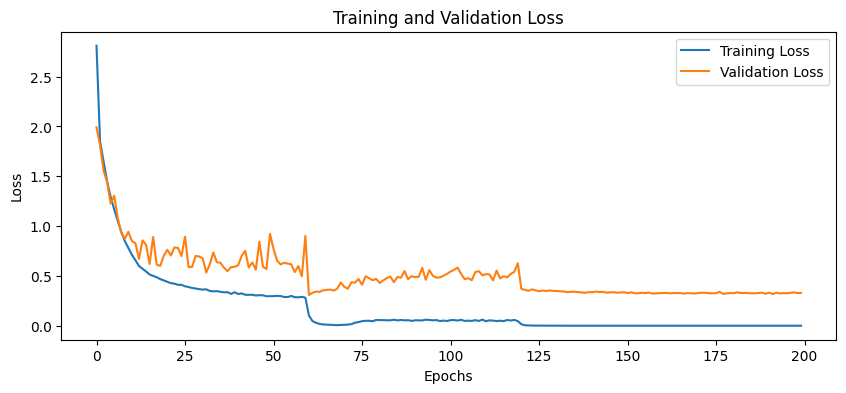

Test set Metrics:
 Average loss: 0.3299 
 F1 Score: 0.9065
Accuracy: 90.67%
Uncertainties: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}
ECE: 0.0491
Mean AUPR: 0.9643
Mean AUC: 0.9939
Mean FPR at 95% Recall: 0.0268
Number of Parameters: 23520842


In [18]:
resnet50_cifr10 = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=10)
resnet50_cifr10.to(device)
summary(resnet50_cifr10, (3, 32, 32))

# Training the model
train_losses, val_losses = train_model(
    model=resnet50_cifr10, 
    train_loader=trainloader10, 
    val_loader=validloader10,
    epochs=200, 
    learning_rate=0.1, 
    gamma_lr=0.2,
    milestones=[60, 120, 160], 
    save_path='./resnet50_cifr10_dropout.pth', 
    Weight_decay=5e-4,
    Momentum=0.9, 
    Optimizer_type='SGD',  
    Loss_fn='CrossEntropyLoss',
    Num_classes=10,
    BNL_enable=False,
    BNL_load_path='./resnet50_cifr10_dropout.pth'
)

# Testing the model with metrics
test_model_with_metrics(
    loss_fn=nn.CrossEntropyLoss(), 
    model=resnet50_cifr10, 
    test_loader=testloader10, 
    load_path="./resnet50_cifr10_dropout.pth",
    calculate_uncert=True, 
    calculate_nll_loss=True, 
    calculate_ece_error=True,
    calculate_auprc=True, 
    calculate_auc_roc=True, 
    calculate_fpr_95=True, 
    count_params=True,
    plot_uncert=False, 
    predict_uncert=False, 
    model_class=resnet50_cifr10.__class__, 
    models=[torch.load('./resnet50_cifr10_dropout.pth')],
    num_samples=10, 
    num_classes=10
)



### ResNet50 on CIFAR100

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]           4,096
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7          [-1, 256, 32, 32]          16,384
       BatchNorm2d-8          [-1, 256, 32, 32]             512
            Conv2d-9          [-1, 256, 32, 32]          16,384
      BatchNorm2d-10          [-1, 256, 32, 32]             512
       Bottleneck-11          [-1, 256, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          16,384
      BatchNorm2d-13           [-1, 64, 32, 32]             128
           Conv2d-14           [-1, 64,

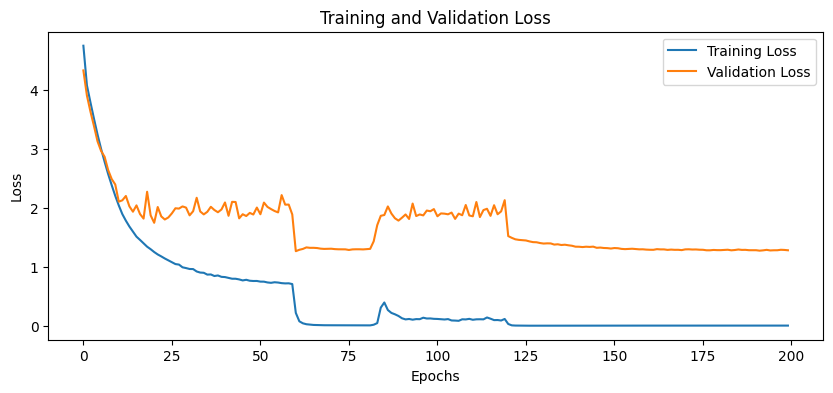

Test set Metrics:
 Average loss: 1.3010 
 F1 Score: 0.6720
Accuracy: 67.47%
Uncertainties: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 0.0, 93: 0.0, 94: 0.0, 95: 0.0, 96: 0.0, 97: 0.0, 98: 0.0, 99: 0.0}
ECE: 0.0791
Mean A

In [16]:
resnet50_cifr100 = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=100)
resnet50_cifr100.to(device)
summary(resnet50_cifr100, (3, 32, 32))

# Training the model
train_losses, val_losses = train_model(
    model=resnet50_cifr100, 
    train_loader=trainloader100, 
    val_loader=validloader100,
    epochs=200, 
    learning_rate=0.1, 
    gamma_lr=0.2,
    milestones=[60, 120, 160], 
    save_path='./resnet50_cifr100_dropout.pth', 
    Weight_decay=5e-4,
    Momentum=0.9, 
    Optimizer_type='SGD',  
    Loss_fn='CrossEntropyLoss',
    Num_classes=100,
    BNL_enable=False,
    BNL_load_path='./resnet50_cifr100_dropout.pth'
)

# Testing the model with metrics
test_model_with_metrics(
    loss_fn=nn.CrossEntropyLoss(), 
    model=resnet50_cifr100, 
    test_loader=testloader100, 
    load_path="./resnet50_cifr100_dropout.pth",
    calculate_uncert=True, 
    calculate_nll_loss=True, 
    calculate_ece_error=True,
    calculate_auprc=True, 
    calculate_auc_roc=True, 
    calculate_fpr_95=True, 
    count_params=True,
    plot_uncert=False, 
    predict_uncert=False, 
    model_class=resnet50_cifr100.__class__, 
    models=[torch.load('./resnet50_cifr100_dropout.pth')],
    num_samples=100, 
    num_classes=100
)



### ResNet50 on CIFAR10 with ABNLL

In [46]:
resnet50_cifr10_bnl = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=10,norm_layer=BNL)
resnet50_cifr10_bnl.to(device)
# summary(resnet50_cifr10_bnl.to(device), (3, 64, 64))

# Training the model
train_losses, val_losses = train_model(
    model=resnet50_cifr10_bnl, 
    train_loader=trainloader10, 
    val_loader=validloader10,
    epochs=20, 
    learning_rate=0.1, 
    gamma_lr=0.2,
    milestones=[60, 120, 160], 
    save_path='./resnet50_cifr10_bnl_dropout.pth', 
    Weight_decay=5e-4,
    Momentum=0.9, 
    Optimizer_type='SGD',  
    Loss_fn='CustomMAPLoss',
    Num_classes=10,
    BNL_enable=True,
    BNL_load_path='./resnet50_cifr10_dropout.pth'
)

# Testing the model with metrics
test_model_with_metrics(
    loss_fn='CustomMAPLoss', 
    model=resnet50_cifr10_bnl, 
    test_loader=testloader10, 
    load_path="./resnet50_cifr10_bnl_dropout.pth",
    calculate_uncert=True, 
    calculate_nll_loss=True, 
    calculate_ece_error=True,
    calculate_auprc=True, 
    calculate_auc_roc=True, 
    calculate_fpr_95=True, 
    count_params=True,
    plot_uncert=False, 
    predict_uncert=False, 
    model_class=resnet50_cifr10.__class__, 
    models=[torch.load('./resnet50_cifr10_bnl_dropout.pth')],
    num_samples=10, 
    num_classes=10,
    Weight_decay=5e-4
)



BNL model loaded from ./resnet50_cifr10_dropout.pth
Model weights loaded.


RuntimeError: The size of tensor a (64) must match the size of tensor b (32) at non-singleton dimension 2

In [14]:
resnet50_cifr10_bnl = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=10,norm_layer=ABNN.BNL)
resnet50_cifr10_bnl.to(device)
summary(resnet50_cifr10_bnl, (3, 32, 32))

# Training the model
train_losses, val_losses = train_model(
    model=resnet50_cifr10_bnl, 
    train_loader=trainloader10, 
    val_loader=validloader10,
    epochs=200, 
    learning_rate=0.1, 
    gamma_lr=0.2,
    milestones=[60, 120, 160], 
    save_path='./resnet50_cifr10_bnl_dropout_no_closs.pth', 
    Weight_decay=5e-4,
    Momentum=0.9, 
    Optimizer_type='SGD',  
    Loss_fn='CrossEntropyLoss',
    Num_classes=10,
    BNL_enable=True,
    BNL_load_path='./resnet50_cifr10_dropout.pth'
)

# Testing the model with metrics
test_model_with_metrics(
    loss_fn=nn.CrossEntropyLoss(), 
    model=resnet50_cifr10_bnl, 
    test_loader=testloader10, 
    load_path="./resnet50_cifr10_bnl_dropout_no_closs.pth",
    calculate_uncert=True, 
    calculate_nll_loss=True, 
    calculate_ece_error=True,
    calculate_auprc=True, 
    calculate_auc_roc=True, 
    calculate_fpr_95=True, 
    count_params=True,
    plot_uncert=False, 
    predict_uncert=False, 
    model_class=resnet50_cifr10.__class__, 
    models=[torch.load('./resnet50_cifr10_bnl_dropout_no_closs.pth')],
    num_samples=10, 
    num_classes=10,
    Weight_decay=5e-4
)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
               BNL-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]           4,096
               BNL-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
               BNL-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 256, 32, 32]          16,384
               BNL-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 256, 32, 32]          16,384
              BNL-10          [-1, 256, 32, 32]               0
       Bottleneck-11          [-1, 256, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          16,384
              BNL-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

KeyboardInterrupt: 

### ResNet50 on CIFAR100 with ABNLL

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
               BNL-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]           4,096
               BNL-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
               BNL-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 256, 32, 32]          16,384
               BNL-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 256, 32, 32]          16,384
              BNL-10          [-1, 256, 32, 32]               0
       Bottleneck-11          [-1, 256, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          16,384
              BNL-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

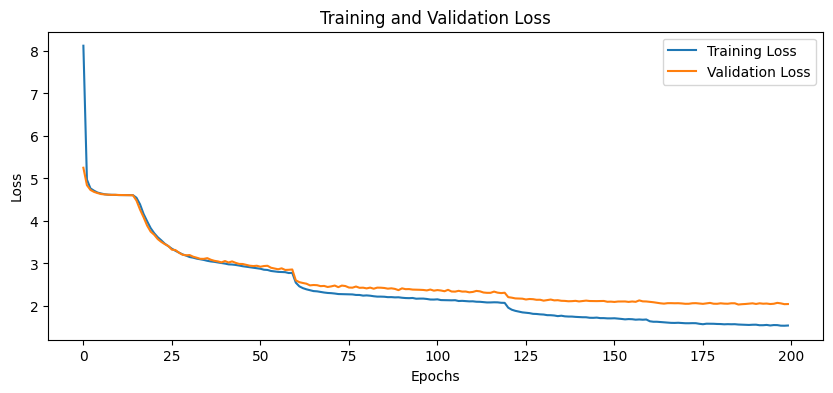

Test set Metrics:
 Average loss: 2.0579 
 F1 Score: 0.4542
Accuracy: 45.73%
Uncertainties: {0: 0.035391037265071645, 1: 0.038705403757789594, 2: 0.014889371365090763, 3: 0.011086488048724214, 4: 0.010842713635116652, 5: 0.03102937704355454, 6: 0.035599507616163886, 7: 0.02971476864283024, 8: 0.03478135778981167, 9: 0.029747355712710748, 10: 0.020902985472375485, 11: 0.013519367292280583, 12: 0.03146669738699567, 13: 0.023905671041854492, 14: 0.026112675726020322, 15: 0.026241729831812773, 16: 0.025741345698048968, 17: 0.03723171232832101, 18: 0.02641180921345949, 19: 0.02267663203938795, 20: 0.0295008018484027, 21: 0.03859119808420556, 22: 0.023467539058651263, 23: 0.03414070460530638, 24: 0.03371486706280355, 25: 0.022256766364945016, 26: 0.028768205574469567, 27: 0.014654173209419242, 28: 0.032045373877303975, 29: 0.027755288643596752, 30: 0.020484654432146858, 31: 0.02617099653421478, 32: 0.0250511025447942, 33: 0.028656364390653007, 34: 0.025175412432362095, 35: 0.00983678851795654

In [17]:
resnet50_cifr100_bnl = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=100,norm_layer=ABNN.BNL)
resnet50_cifr100_bnl.to(device)
summary(resnet50_cifr100_bnl, (3, 32, 32))

# Training the model
train_losses, val_losses = train_model(
    model=resnet50_cifr100_bnl, 
    train_loader=trainloader100, 
    val_loader=validloader100,
    epochs=200, 
    learning_rate=0.1, 
    gamma_lr=0.2,
    milestones=[60, 120, 160], 
    save_path='./resnet50_cifr100_bnl_dropout_no_closs.pth', 
    Weight_decay=5e-4,
    Momentum=0.9, 
    Optimizer_type='SGD',  
    Loss_fn='CrossEntropyLoss',
    Num_classes=100,
    BNL_enable=True,
    BNL_load_path='./resnet50_cifr100_dropout.pth'
)

# Testing the model with metrics
test_model_with_metrics(
    loss_fn=nn.CrossEntropyLoss(), 
    model=resnet50_cifr100_bnl, 
    test_loader=testloader100, 
    load_path="./resnet50_cifr100_bnl_dropout_no_closs.pth",
    calculate_uncert=True, 
    calculate_nll_loss=True, 
    calculate_ece_error=True,
    calculate_auprc=True, 
    calculate_auc_roc=True, 
    calculate_fpr_95=True, 
    count_params=True,
    plot_uncert=False, 
    predict_uncert=False, 
    model_class=resnet50_cifr100_bnl.__class__, 
    models=[torch.load('./resnet50_cifr100_bnl_dropout_no_closs.pth')],
    num_samples=100, 
    num_classes=100,
    Weight_decay=5e-4
)

